In [82]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pymorphy2
from tqdm import tqdm
tqdm.pandas(desc="Статус выполнения!")
import numpy as np
from sklearn.ensemble import RandomForestClassifier

#### Считаем данные

In [2]:
#Cчитываем данные
train = pd.read_csv('train.csv', sep = '\t')
test = pd.read_csv('test.csv', sep = '\t')
#other = pd.read_csv('other.csv', sep = '\t')
submit = pd.read_csv('sampleSubmission.csv')

#### Исследуем данные

In [3]:
train.head()

,id,name,description,target
0,0,Заведующий отделом/секцией в магазин YORK (Уру...,<p><strong>В НОВЫЙ МАГАЗИН YORK (хозтовары) пр...,1
1,1,Наладчик станков и манипуляторов с ПУ,Обязанности:работа на токарных станках с ЧПУ T...,0
2,2,Разработчик С++ (Криптограф),<strong>Требования:</strong> <ul> <li>Опыт про...,0
3,3,Фрезеровщик,<p>Условия:</p> <ul> <li>На работу вахтовым ме...,0
4,4,Мерчендайзер/продавец-консультант,<p><strong>Компания Палладиум Стандарт - призн...,1


In [4]:
train.shape

(200000, 4)

In [5]:
train.target.mean()

0.46782

In [6]:
test.head()

,id,name,description
0,200000,Дизайнер-консультант мебели,<p><strong>Обязанности:</strong></p> <ul> <li>...
1,200001,Продавец-консультант (ТЦ на Пушкина),<p><strong>Обязанности</strong>:</p> <p>∙ конс...
2,200002,Менеджер по продажам,<p>Торговый Дом «Форт» это ведущая компания Пе...
3,200003,Продавец-консультант в магазин одежды (ТЦ Волн...,<p><strong>Требуются продавцы консультанты в м...
4,200004,Специалист по охране труда,<strong>Обязанности:</strong> <ul> <li> <p>осу...


In [7]:
test.shape

(170179, 3)

In [8]:
#Функция которая очистит теги HTML
def remove_html(element):
    bs=BeautifulSoup(element, "lxml")
    print( bs.get_text())
    return bs.get_text()

In [9]:
#пакет требует колосальных ресурсов. 7 часов пыталось по одной колонке выполнить преобразование. Так и не досчиталою (((
"""#приведём слова в исходную форму
import pymystem3
mystem=pymystem3.Mystem()

####

#Функция преобразования слов в начальную форму
def osnova_slov(text):
    lemma = mystem.lemmatize(text)
    text = ''.join(lemma)
    return text[:-1]"""

"#приведём слова в исходную форму\nimport pymystem3\nmystem=pymystem3.Mystem()\n\n####\n\n#Функция преобразования слов в начальную форму\ndef osnova_slov(text):\n    lemma = mystem.lemmatize(text)\n    text = ''.join(lemma)\n    return text[:-1]"

In [10]:
#заменим на аналог, который работает побыстрее...
morph=pymorphy2.MorphAnalyzer() 
def getMeaningfullWords(text):
    words=[]
    tokens=re.findall('[А-Яа-яЁё]+\-[А-Яа-яЁё]+|[А-Яа-яЁё]+', text)
    for t in tokens:
        pv=morph.parse(t)
        for p in pv:
            if p.tag.POS in ['ADJF', 'NOUN', 'VERB']:
                words.append(p.normal_form)
                break
    words = ' '.join(words)
    return words

#### Создадим мини дата сет для отработки алгоритма

In [15]:
#Создадим мини дата сет для отработки алгоритма
train_mini_one = train[train['target']==1].head(1000)
train_mini_zero = train[train['target']==0].head(1000)
train_mini = train_mini_one.append(train_mini_zero)

In [31]:
print(train_mini.iloc[1,[1,2]])
print(train_mini.shape)

name                           Мерчендайзер/продавец-консультант
description    <p><strong>Компания Палладиум Стандарт - призн...
Name: 4, dtype: object
(2000, 4)


In [34]:
#вытаскиваем значимые слова в описаниях и названиях
train_mini['description'] = train_mini.description.apply(lambda x: getMeaningfullWords(x))
train_mini['name'] = train_mini.name.apply(lambda x: getMeaningfullWords(x))

In [38]:
train_mini.head(2)

,id,name,description,target
0,0,отдел секция век магазин уручей,век новый магазин хозтовары приглашать постоян...,1
4,4,мерчендайзер продавец-консультант,компания палладиум стандарт признанный лидер п...,1


In [39]:
train_mini['total'] = train_mini['name'] + ' ' + train_mini['description']

In [42]:
train_mini.head()

,id,name,description,target,total
0,0,отдел секция век магазин уручей,век новый магазин хозтовары приглашать постоян...,1,отдел секция век магазин уручей век новый мага...
4,4,мерчендайзер продавец-консультант,компания палладиум стандарт признанный лидер п...,1,мерчендайзер продавец-консультант компания пал...
6,6,торговый представитель,стабильный исполняющий направление заморозка т...,1,торговый представитель стабильный исполняющий ...
7,7,торговый представитель,обязанность функционал работа торговый предста...,1,торговый представитель обязанность функционал ...
8,8,менеджер продажа,обязанность продажа садовый лесопарковый техни...,1,менеджер продажа обязанность продажа садовый л...


In [45]:
#удалим лишние колонки
train_mini.drop(['name','description'], inplace = True, axis = 1)

KeyError: "labels ['name' 'description'] not contained in axis"

In [47]:
train_mini.head()

,id,target,total
0,0,1,отдел секция век магазин уручей век новый мага...
4,4,1,мерчендайзер продавец-консультант компания пал...
6,6,1,торговый представитель стабильный исполняющий ...
7,7,1,торговый представитель обязанность функционал ...
8,8,1,менеджер продажа обязанность продажа садовый л...


In [48]:
#Аналогично весь датасет был обработан на более производительном пк.

#### Построим модель на всём датасете

In [11]:
#скачиваем подготовленные данные для обучения с помощью пакеиа
processing = pd.read_csv('train-test_meaningfull.csv')
processing.shape

(370179, 3)

In [12]:
#Преобразуем текст в вектора.
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [13]:
#построим вектора в виде разреженной матрици
train_dict = vect.fit_transform(processing['all_words'])

In [14]:
train_dict

<370179x89095 sparse matrix of type '<class 'numpy.int64'>'
	with 28916053 stored elements in Compressed Sparse Row format>

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_dict[:200000], train.target, test_size=0.33, random_state=42, stratify = train.target)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
clf = LogisticRegression(C = 1, n_jobs=-1)

SyntaxError: unexpected EOF while parsing (<ipython-input-19-f390195d5b8f>, line 1)

In [18]:
clf.fit(X_train, y_train)
y_predict = clf.predict_proba(X_test)

C:\Users\morvla\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


In [25]:
score = roc_auc_score(y_test, y_predict[:,1])

0.9878347797219496

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

(-0.01, 1.01)

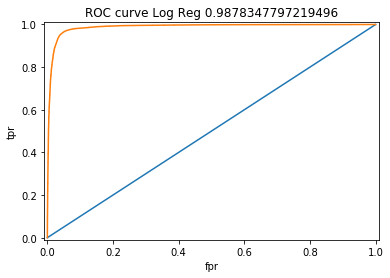

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_predict[:,1])
plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.title('ROC curve Log Reg ' + str(roc_auc_score(y_test, y_predict[:,1])))
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

#### Понастраиваем параметр

In [55]:
c = list(range(1,101,10))

In [56]:
c

[1, 11, 21, 31, 41, 51, 61, 71, 81, 91]

In [57]:
auc_scores = []

In [58]:
for x in c:
    clf = LogisticRegression(C = x, n_jobs=-1)
    clf.fit(X_train,y_train)
    y_predict = clf.predict_proba(X_test)
    auc_scores.append(roc_auc_score(y_test, y_predict[:,1]))

C:\Users\morvla\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


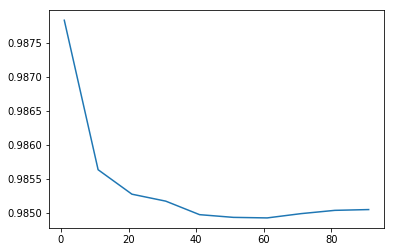

In [59]:
plt.plot(c,auc_scores)

In [ ]:
#попробуем значения менее 1

In [71]:
c_1 = np.arange(0.1,1,0.1)

In [72]:
for x in c_1:
    clf = LogisticRegression(C = x, n_jobs=-1)
    clf.fit(X_train,y_train)
    y_predict = clf.predict_proba(X_test)
    auc_scores.append(roc_auc_score(y_test, y_predict[:,1]))

C:\Users\morvla\AppData\Local\Continuum\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


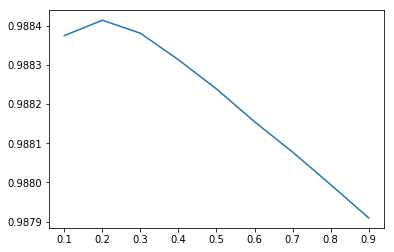

In [80]:
plt.plot(c_1,auc_scores[-9:])

In [ ]:
# лучшее что можно получить на лог регрессии это 0.9884

#### Тестируем случайный лес

In [83]:
rf = RandomForestClassifier(n_estimators = 10,random_state=17, n_jobs=-1)
#rf = RandomForestClassifier(n_estimators = 10,max_depth=10, random_state=17, n_jobs=-1, verbose = 1, max_features = None)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [87]:
y_predict = rf.predict_proba(X_test)

In [88]:
roc_auc_score(y_test, y_predict[:,1])

0.9840224889256193

In [89]:
est = range(10,100,10)
roc_score_rf = []
for i in est:
    rf = RandomForestClassifier(n_estimators = i,random_state=17, n_jobs=-1)
    #rf = RandomForestClassifier(n_estimators = 10,max_depth=10, random_state=17, n_jobs=-1, verbose = 1, max_features = None)
    rf.fit(X_train, y_train)
    y_predict = rf.predict_proba(X_test)
    roc_score_rf.append(roc_auc_score(y_test, y_predict[:,1]))
    

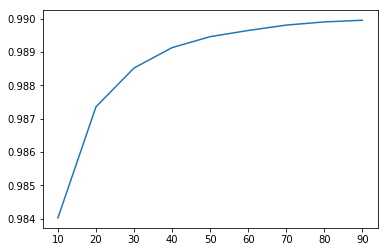

In [91]:
#выведем результаты
plt.plot(est,roc_score_rf)

In [92]:
#попробуем научить на от 100 до 200 "пней" но с шагом 30=)

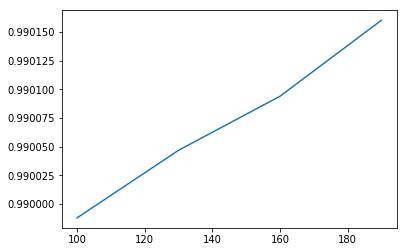

In [93]:
est = range(100,201,30)
roc_score_rf = []
for i in est:
    rf = RandomForestClassifier(n_estimators = i,random_state=17, n_jobs=-1)
    #rf = RandomForestClassifier(n_estimators = 10,max_depth=10, random_state=17, n_jobs=-1, verbose = 1, max_features = None)
    rf.fit(X_train, y_train)
    y_predict = rf.predict_proba(X_test)
    roc_score_rf.append(roc_auc_score(y_test, y_predict[:,1]))
plt.plot(est,roc_score_rf)

100%|████████████████████████████████████████| 3/3 [1:07:34<00:00, 1351.59s/it]


ValueError: x and y must have same first dimension, but have shapes (1,) and (3,)

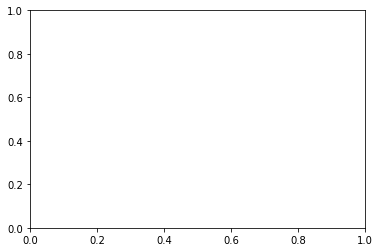

In [94]:
#растёт достаточно неплохо, попробуем еще добавить 
est = tqdm(range(230,320,30))
roc_score_rf = []
for i in est:
    rf = RandomForestClassifier(n_estimators = i,random_state=17, n_jobs=-1)
    #rf = RandomForestClassifier(n_estimators = 10,max_depth=10, random_state=17, n_jobs=-1, verbose = 1, max_features = None)
    rf.fit(X_train, y_train)
    y_predict = rf.predict_proba(X_test)
    roc_score_rf.append(roc_auc_score(y_test, y_predict[:,1]))

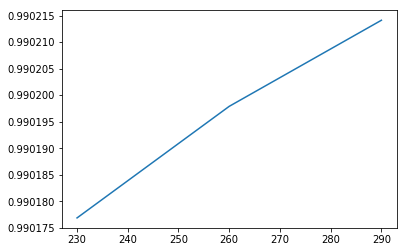

In [102]:
plt.plot(range(230,320,30),roc_score_rf)

In [ ]:
#кажется нужно идти дальше

In [103]:
#растёт достаточно неплохо, попробуем еще добавить 
est = tqdm(range(320,421,30))
roc_score_rf = []
for i in est:
    rf = RandomForestClassifier(n_estimators = i,random_state=17, n_jobs=-1)
    #rf = RandomForestClassifier(n_estimators = 10,max_depth=10, random_state=17, n_jobs=-1, verbose = 1, max_features = None)
    rf.fit(X_train, y_train)
    y_predict = rf.predict_proba(X_test)
    roc_score_rf.append(roc_auc_score(y_test, y_predict[:,1]))

100%|████████████████████████████████████████| 4/4 [1:52:50<00:00, 1692.74s/it]


[0.9902662648861498,
 0.9902511706752583,
 0.9902477174347935,
 0.9902487902906763]

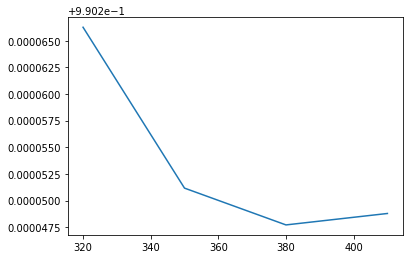

In [111]:
plt.plot(np.arange(320,421,30),roc_score_rf)
roc_score_rf

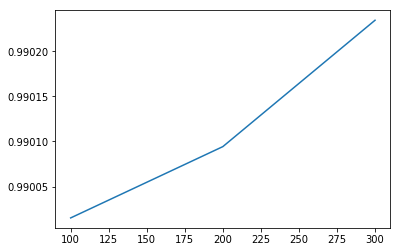

In [124]:
plt.plot(depth,roc_score_rf)

In [129]:
#допустим что 320 деревьев дают лучший результат. попробуем изменить глубину
depth = range(400,701,100)
roc_score_rf = []
for i in depth:
    rf = RandomForestClassifier(n_estimators = 320,random_state=17, n_jobs=-1, verbose = 1,max_depth=  i)
    #rf = RandomForestClassifier(n_estimators = 10,max_depth=10, random_state=17, n_jobs=-1, verbose = 1, max_features = None)
    rf.fit(X_train, y_train)
    y_predict = rf.predict_proba(X_test)
    roc_score_rf.append(roc_auc_score(y_test, y_predict[:,1]))

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 24.8min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 24.9min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 24.5min finished
[Parallel(n_jobs=4)]: Done  42 

In [130]:
roc_score_rf

[0.9902662658082434,
 0.9902662648861498,
 0.9902662662692902,
 0.9902662694966177]

In [131]:
y_test_predict = rf.predict_proba(train_dict[200000:])

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:   25.0s finished


In [132]:
y_test_predict.shape

(170179, 2)

In [133]:
submit['target'] = y_test_predict[:,1]

In [134]:
#submit.reset_index(drop=True, inplace = True)

In [135]:
submit.to_csv('submit_logreg.csv',index= False)